## Calculs du shift en energie, effet AC Stark


Le fait de piéger l'atome dans une pince optique, zone à fort champ, provoque un déplacement de ses niveaux d'énergie, que l'on veut calculer ici. Cet effet nommé AC Stark est comme l'effet Stark vu en M1, dû à l'hamiltonien de perturbation $W = -\vec{d}.\vec{\mathcal{E}}$, mais le champ électrique dépend ici du temps.

On veut calculer le déplacements des niveaux hyperfins de l'atome de Rubidium87, dans le but de calculer la variation d'énergie d'une transition dipolaire-électrique : c'est-à-dire à partir d'un $\Delta E$ associé à une transition entre niveaux non perturbés, nous pouvons calculer la variation $\delta(\Delta E)$. Les figures obtenues n'affichent pas les énergies pures de chaque niveau, mais le __déplacement__ du niveau.

Les formules des déplacements sont tirés de "Le Kien et al, Eur. Phys. J. D 67, 92 (2013)" et font intervenir les polarisabilités dynamiques $\alpha_{nJF}^{s,v,T}$ de chaque niveau de l'atome de Rubidium, qui nous sont fournies par le package Python ARC.

Formule de calcul de shift : (19) de [Le_Kien_2013] :
\begin{equation}
	\Delta E_{AC} = -\frac{|\mathcal{E}|^2}{4}\left\{\alpha_{nJF}^s + C \alpha_{nJF}^v \frac{m_F}{2F} - D \alpha_{nJF}^T \frac{3m_F^2 - F(F+1)}{2F(2F-1)} \right\}
\end{equation}
où C et D sont des coefficients qui dépendent de la polarisation du champ électrique.

Ce à quoi sera ajouté le déplacement Zeeman :
\begin{equation}
	\Delta E_{Z} = \mu_B g_F {B_{ext} m_F}
\end{equation}

In [2]:
# Configure the matplotlib graphics library and configure it to show
# figures inline in the notebook

%matplotlib inline
import matplotlib.pyplot as plt  # Import library for direct plotting functions
import numpy as np               # Import Numerical Python
from IPython.display import display, HTML #Import HTML for formatting output

import sympy.physics.wigner  as wg

import arc
from arc import *                 #Import ARC (Alkali Rydberg Calculator)

from scipy.constants import c, h, physical_constants, m_e, epsilon_0, e, hbar
from scipy.constants import k as kB

from fractions import Fraction
from dataclasses import dataclass


Le code qui suit définit la classe "level" pour un niveau atomique, calcule ses polarisabilités et ses shifts AC Stark et Zeeman :
- calc_alphasJ : calcul des polarisabilités associées au niveau J
- calc_alphasF : calcul des polarisabilités associées au niveau F à partir des polarisabilités du niveau J
- shift        : après avoir appelé les calculs de polarisabilités, calcul du shift AC Stark de chaque niveau |nJF>

In [3]:
"""
Created on Thu Apr 15 11:48:41 2021

@author: Clement

Calculates polarizabilities and energy shift for an atom.
Uses the functionalities of Alkali Rydberg Calculator 
user manual: Computer Phyics Communications 261 (2021) 107814

Underlying formalism: Fam Le Kien et al, Eur. Phys. J. D 67, 92 (2013)
"""

"""
Apr 2023
Code modified by Aurore
"""




#%% Definition of functions and constants

a0 = physical_constants.get('Bohr radius')[0]
mu_b = physical_constants.get('Bohr magneton')[0]
gs = -physical_constants.get('electron g factor')[0]
freq_to_K = h/kB
au_to_freqSI = 2*np.pi*a0**3/(h*c) #Converts atomic units polarisability to SI units frequency
                                #h * nu = 4pi eps_0 a_0^3 * (I/ (2 eps0 c)) * alpha(a.u.)

wpm2_to_mwpum = 1e-9

print('au to SI factor = {}'.format(au_to_freqSI))

@dataclass
class ExperimentData:
    lbda: np.float32 = 820e-9 #820e-9 #Laser wavelength (m)
    P:    np.float32 = 3.6e-3 # power (W)
    w:    np.float32 = 1.2e-6 # waist (m)
    Imax: np.float32 = 0.0
    Bf:   np.float32 = 14 * 1e-4 # Magnetic field (T), along the quantization (z) axis
    def setImax(self):
        self.Imax = 2 * self.P/ (np.pi * self.w**2) # maximum intensity (W/m^2)
        return self.Imax
    
    def __str__(self):
        return 'lambda = {}, P={} W, w={} m, Imax={:.4f}mW/um^2, Bf={}'.format(self.lbda, self.P, self.w, self.Imax*wpm2_to_mwpum, self.Bf)

class level:
    ''' Energy level of definite quantum numbers n, L, J, F and S'''
    def __init__(self, atome):
        self.atom = atome
        self.n = self.atom.groundStateN
        self.S = 0.5
        self.L = 0
        self.J = 0.5
        self.I = self.atom.I
        self.F = self.J + self.I
        self.alphasJ = np.zeros(5, dtype=np.float32)
        self.alphasF = np.zeros(3, dtype=np.float32)
        self.closestState = []
    
    L_to_string = {0: 'S', 1: 'P', 2: 'D', 3: 'F', 4: 'G', 5: 'H', 6: 'I'}

    def __str__(self):
        return '{:d}{}_{}, F={:1.0f}'.format(self.n, self.L_to_string[self.L], str(Fraction(self.J)), self.F)
    
    def calc_alphasJ(self, lbda, nmin, nmax, p_units='au'):
        '''Calcualtes the dynamic polarizabilities of the J level
            - alpha0 is the scalar polarizablity
            - alpha1 is the vector polarizability
            - alpha2 is the tensor polarizability
            - alphaC is the core polarizability
            - alphaP is the ponderomotive ''polarizability''
        '''
        calc = arc.DynamicPolarizability(self.atom, self.n, self.L, self.J)
        calc.defineBasis(nmin, nmax)
        alpha0, alpha1, alpha2, alphaC, alphaP, closestState = calc.getPolarizability(lbda, units=p_units, accountForStateLifetime=(True))
        
        self.alphasJ = np.array([alpha0, alpha1, alpha2, alphaC, alphaP])
        #print('Level {} - Pola alphasJ in units {}:'.format(self, p_units))
        #print(self.alphasJ)
        self.closestState = closestState

    def calc_alphasF(self, lbda, nmin, nmax, units='au', recalc=True):
        ''' Calculates the dynamic polarizabilities of the F level:
            - alpha0 is the scalar polarizablity
            - alpha1 is the vector polarizability
            - alpha2 is the tensor polarizability
        '''
        test = np.sum(self.alphasJ**2)
        if test<1e-10 or recalc:
            self.calc_alphasJ(lbda, nmin, nmax, p_units = units)
        self.alphasF = self.alphasJtoF(self.alphasJ, self.F, self.I, self.J)
        print('Level {} - Pola alphasF in units {}:'.format(self, units))
        print(self.alphasF)
    
    def alphasJtoF(self, alphasJ, F, I, J):
        ''' Converts J polarization components to F polarization components.
            Note : The alphas J polarizabilities calculated by ARC are the alphas^(s,v,T) of formula (16)
            in the Le_Kien, EPJD paper'''
        alphasF = np.empty(3)

        alphasF[0] = alphasJ[0]

        # Inverted formulas (16) of EPJD - Le Kien 2013
        alphasJ_reduced = np.copy(alphasJ)
        if J==0:
            alphasJ_reduced[1] = 0
        else:
            alphasJ_reduced[1] = -np.sqrt((J+1)*(2*J+1)/(2*J)) * alphasJ[1]

        if J==0.5:
            alphasJ_reduced[2] = 0
        else:
            alphasJ_reduced[2] = -np.sqrt(3 * (J+1) * (2*J+1) * (2*J+3) / (2*J * (2*J-1))) \
                * alphasJ[2]

        # Formulas (18) of EPJD - Le Kien 2013
        alphasF[1] = (-1)**(J+I+F) * np.sqrt((2*F) * (2*F+1) / (F+1)) \
            * wg.wigner_6j(F, 1, F, J, I, J) * alphasJ_reduced[1]
        alphasF[2] = -(-1)**(J+I+F) * np.sqrt( 2 *F * (2*F-1) * (2*F+1) / (3 * (F+1) * (2*F+3))) \
            * wg.wigner_6j(F, 2, F, J, I, J) * alphasJ_reduced[2]

        return alphasF
    
    def Landes(self):
        ''' Returns the Landé factors gJ and gF'''
        J = self.J
        L = self.L
        S = self.S
        F = self.F
        I = self.I
        
        
        gl = 1- m_e/self.atom.mass

        # Formulas (22-23) of EPJD - Le Kien 2013
        gJ = gl * (J*(J+1) - S*(S+1) + L*(L+1)) / (2*J*(J+1)) \
            + gs * (J*(J+1) + S*(S+1) - L*(L+1)) / (2*J*(J+1))

        if F==0:
            gF = 0.5 * gJ
        else:
            gF = gJ * (F*(F+1) - I*(I+1) + J*(J+1)) / (2*F*(F+1))

        return gJ, gF

    def shift(self, m, Efield, Bfield, units, include_pondero=False):
        ''' Calculates the energy shift (in Hz) in the given electric and magnetic fields for the |F, m> level
            # From formulas (19-20) of EPJD - Le Kien 2013
            -Code valid only for B field along the quantization (z) axis and an electric field with pure pi, sigma+ 
             or sigma- polarization
            -Ponderomotive shift is included only if include_pondero is set to True'''
        test = np.sum(self.alphasF**2)
        if test<1e-10:
            return np.NaN
        else:
            factor = (1.0/(2*c*epsilon_0) if units == 'SI' else au_to_freqSI) # polarizabilities in SI are in Hz / (|E|²)
            #print("Polarizabilities factor = {}".format(factor))
            amp = - factor * Efield.I # will multiply at the end for all polarizabilities
            
            scalar = self.alphasF[0]
            
            if self.F==0:
                vector = 0
                tensor = 0
            else:
                vector = self.alphasF[1]  * m/(2*self.F) * (Efield.sp**2 - Efield.sm**2)
                tensor = self.alphasF[2] * 1/(2*self.F*(2*self.F-1)) * \
                     (-( 3 * m**2 - self.F * (self.F+1))* (Efield.sp**2 + Efield.sm**2)  + 2*(3 * m**2 - self.F*(self.F+1)) * Efield.pi**2)

            core = self.alphasJ[3]
            
            if include_pondero:
                pondero = self.alphasJ[4]
            else:
                pondero = 0


            gJ, gF = self.Landes()
            Zeemanshift = mu_b * gF * m * Bfield / h # resultat en Hz = energie / h

            return Zeemanshift + amp * (scalar + vector + tensor + core + pondero) # resultat en Hz = energie / h



class Efield:
    ''' Electric field object with intensity and polarization components'''
    def __init__(self):
        self.pol = np.zeros(3, dtype=np.float32)
        self.sp = 0.
        self.sm = 0.
        self.pi = 0.
        self.E = 1.
        self.I = self.E**2

    def normalize(self):
        ''' Normalizes the polarization vector and calculates the sigma+, - and pi components'''
        norm = np.sqrt(np.sum(np.abs(self.pol)**2))
        self.E *= norm
        self.I = self.E**2
        self.pol /= norm
        self.sp = (self.pol[0] - 1j * self.pol[1]) / np.sqrt(2)
        self.sm = (self.pol[0] + 1j * self.pol[1]) / np.sqrt(2)
        self.pi = self.pol[2]


au to SI factor = 4.68712499019164e-06


## Fonction pour représenter les shifts  $(\delta E)$ de chaque niveau et la transition visée

In [10]:
def printShifts(gnd, exc, expdata, shifts_gnd, shifts_exc, mFList1, mFList2, M_F_transition):
    Imax = expdata.Imax
    print('Max Intensity: Imax = {:.4e} mW/µm2'.format(Imax*wpm2_to_mwpum))
    #print('Light shift of level {} (averaged over all M_F): {:.4f} MHz \t {:.4f} µK'.format(str(gnd), np.average(shifts_gnd)*1e-6, np.average(shifts_gnd)*freq_to_K*1e6))
    M_F_gnd_ind = np.argwhere(mFList1==M_F_transition[0])[0][0]
    M_F_exc_ind = np.argwhere(mF2List==M_F_transition[1])[0][0]
    print('Light shift of level {}, mF = {:.0f}: {:.4e} MHz \n'.format(str(gnd), M_F_transition[0], 1e-6*(shifts_gnd[M_F_gnd_ind])))
    
    print('Light shift of level {} (averaged over all M_F): {:.4f} MHz'.format(str(exc), np.average(shifts_exc)*1e-6))
    print('Light shift of level {}, mF = {:.0f}: {:.4e} MHz'.format(str(exc), M_F_transition[1], 1e-6*(shifts_exc[M_F_exc_ind])))
    #print('Light shift of gnd --> exc transition (averaged over all M_F): {:.4f} MHz'.format((np.average(shifts_exc)-np.average(shifts_gnd))*1e-6))
    delta = (shifts_exc[M_F_exc_ind]-shifts_gnd[M_F_gnd_ind])*1e-6
    print('Light shift of gnd, mF = {:.0f} --> exc transition, mF = {:.0f}: {:.4f} MHz'.format(mFList1[M_F_gnd_ind], mFList2[M_F_exc_ind], delta))

    print('\n')
    print('Light shift averaged of level {}: {:.4e} MHz/(mW/µm2)'.format(str(gnd), 1e-6*np.average(shifts_gnd)/(Imax*wpm2_to_mwpum)))
    print('Light shift averaged of level {}: {:.4e} MHz/(mW/µm2)'.format(str(exc),  1e-6*np.average(shifts_exc)/(Imax*wpm2_to_mwpum)))
    print('Light shift of level {}, mF = {:.0f}: {:.4e} MHz/(mW/µm2)'.format(str(exc), mFList2[M_F_exc_ind], 1e-6*(shifts_exc[-1])/(Imax*wpm2_to_mwpum)))
    print('Light shift averaged of gnd --> exc transition: {:.4e} MHz/(mW/µm2)'.format( 1e-6*(np.average(shifts_exc)-np.average(shifts_gnd))/(Imax*wpm2_to_mwpum)))
    print('Light shift of gnd, mF = {:.0f} --> exc transition, mF = {:.0f}: {:.4f} MHz/(mW/µm2)'.format(mFList1[M_F_gnd_ind], mFList2[M_F_exc_ind], (shifts_exc[M_F_exc_ind]-shifts_gnd[M_F_gnd_ind])*1e-6/(Imax*wpm2_to_mwpum)))
    print('\n')
    print('Light shift averaged of level {}: {:.4e} µK/(mW/µm2)'.format(str(gnd),  1e6*np.average(shifts_gnd)/(Imax*wpm2_to_mwpum)*freq_to_K))
    print('Light shift averaged of level {}: {:.4f} µK/MHz of transition'.format(str(gnd), 1e6*np.average(shifts_gnd)*freq_to_K/( 1e-6*(np.average(shifts_exc)-np.average(shifts_gnd)))))
    print('Light shift averaged of level {}: {:.4f} MHz/MHz of transition'.format(str(gnd), np.average(shifts_gnd)/(np.average(shifts_exc)-np.average(shifts_gnd))))

    plt.figure(1)
    plt.clf()
    plt.plot(mFList1, shifts_gnd*1e-6, 'r--_', markersize=25,label=str(gnd))
    plt.plot(mFList2, shifts_exc*1e-6, 'b--_', markersize=25,label=str(exc))
    plt.xlabel('m_F')
    plt.ylabel('Shift (MHz)')
    plt.title(str(expData))# + "\n /!\ zero is the energy level without AC Stark and Zeeman effects")
    plt.legend()

    # Add an arrow to indicate the transition of interest
    arrow_style = {
        "head_width": 0.2,
        "head_length": 1.8,
        "linewidth" : 2.0,
        "length_includes_head" : True,
        "color":"g"
    }
    L=mFList2[M_F_exc_ind]-mFList1[M_F_gnd_ind]
    H=shifts_exc[M_F_exc_ind]*1e-6 - shifts_gnd[M_F_gnd_ind]*1e-6
    plt.arrow(x=mFList1[M_F_gnd_ind], y=shifts_gnd[M_F_gnd_ind]*1e-6, dx=L, dy=H, **arrow_style)
    plt.arrow(x=mFList1[M_F_gnd_ind]+L, y=shifts_gnd[M_F_gnd_ind]*1e-6 + H, dx=-L, dy=-H, **arrow_style)
    
    #plt.annotate(r'$\Delta(\delta E) = {:.4f}$'.format(delta),
    #             xy=(mFList1[M_F_gnd_ind]+L/2 - 0.75, shifts_gnd[M_F_gnd_ind]*1e-6 + H/2),
    #             xytext=(10, -10),
    #             textcoords='offset points')
    
    # Add temperature axis
    ax = plt.gca()
    ax2 = ax.twinx()
    ax2.set_ylabel('Depth (mK)')
    y1, y2 = ax.get_ylim()
    coeff = h/kB * 1e9
    ax2.set_ylim(y1 * coeff, y2 * coeff)

    #plt.savefig("figure.pdf", bbox_inches = 'tight')
    plt.show()

Allons-y Alonso, calculons les déplacements d'énergie de deux transitions hyperfines.
Pour rappel, la structure des niveaux hyperfins D2 du Rubidium : tirée de https://steck.us/alkalidata/rubidium87numbers.pdf

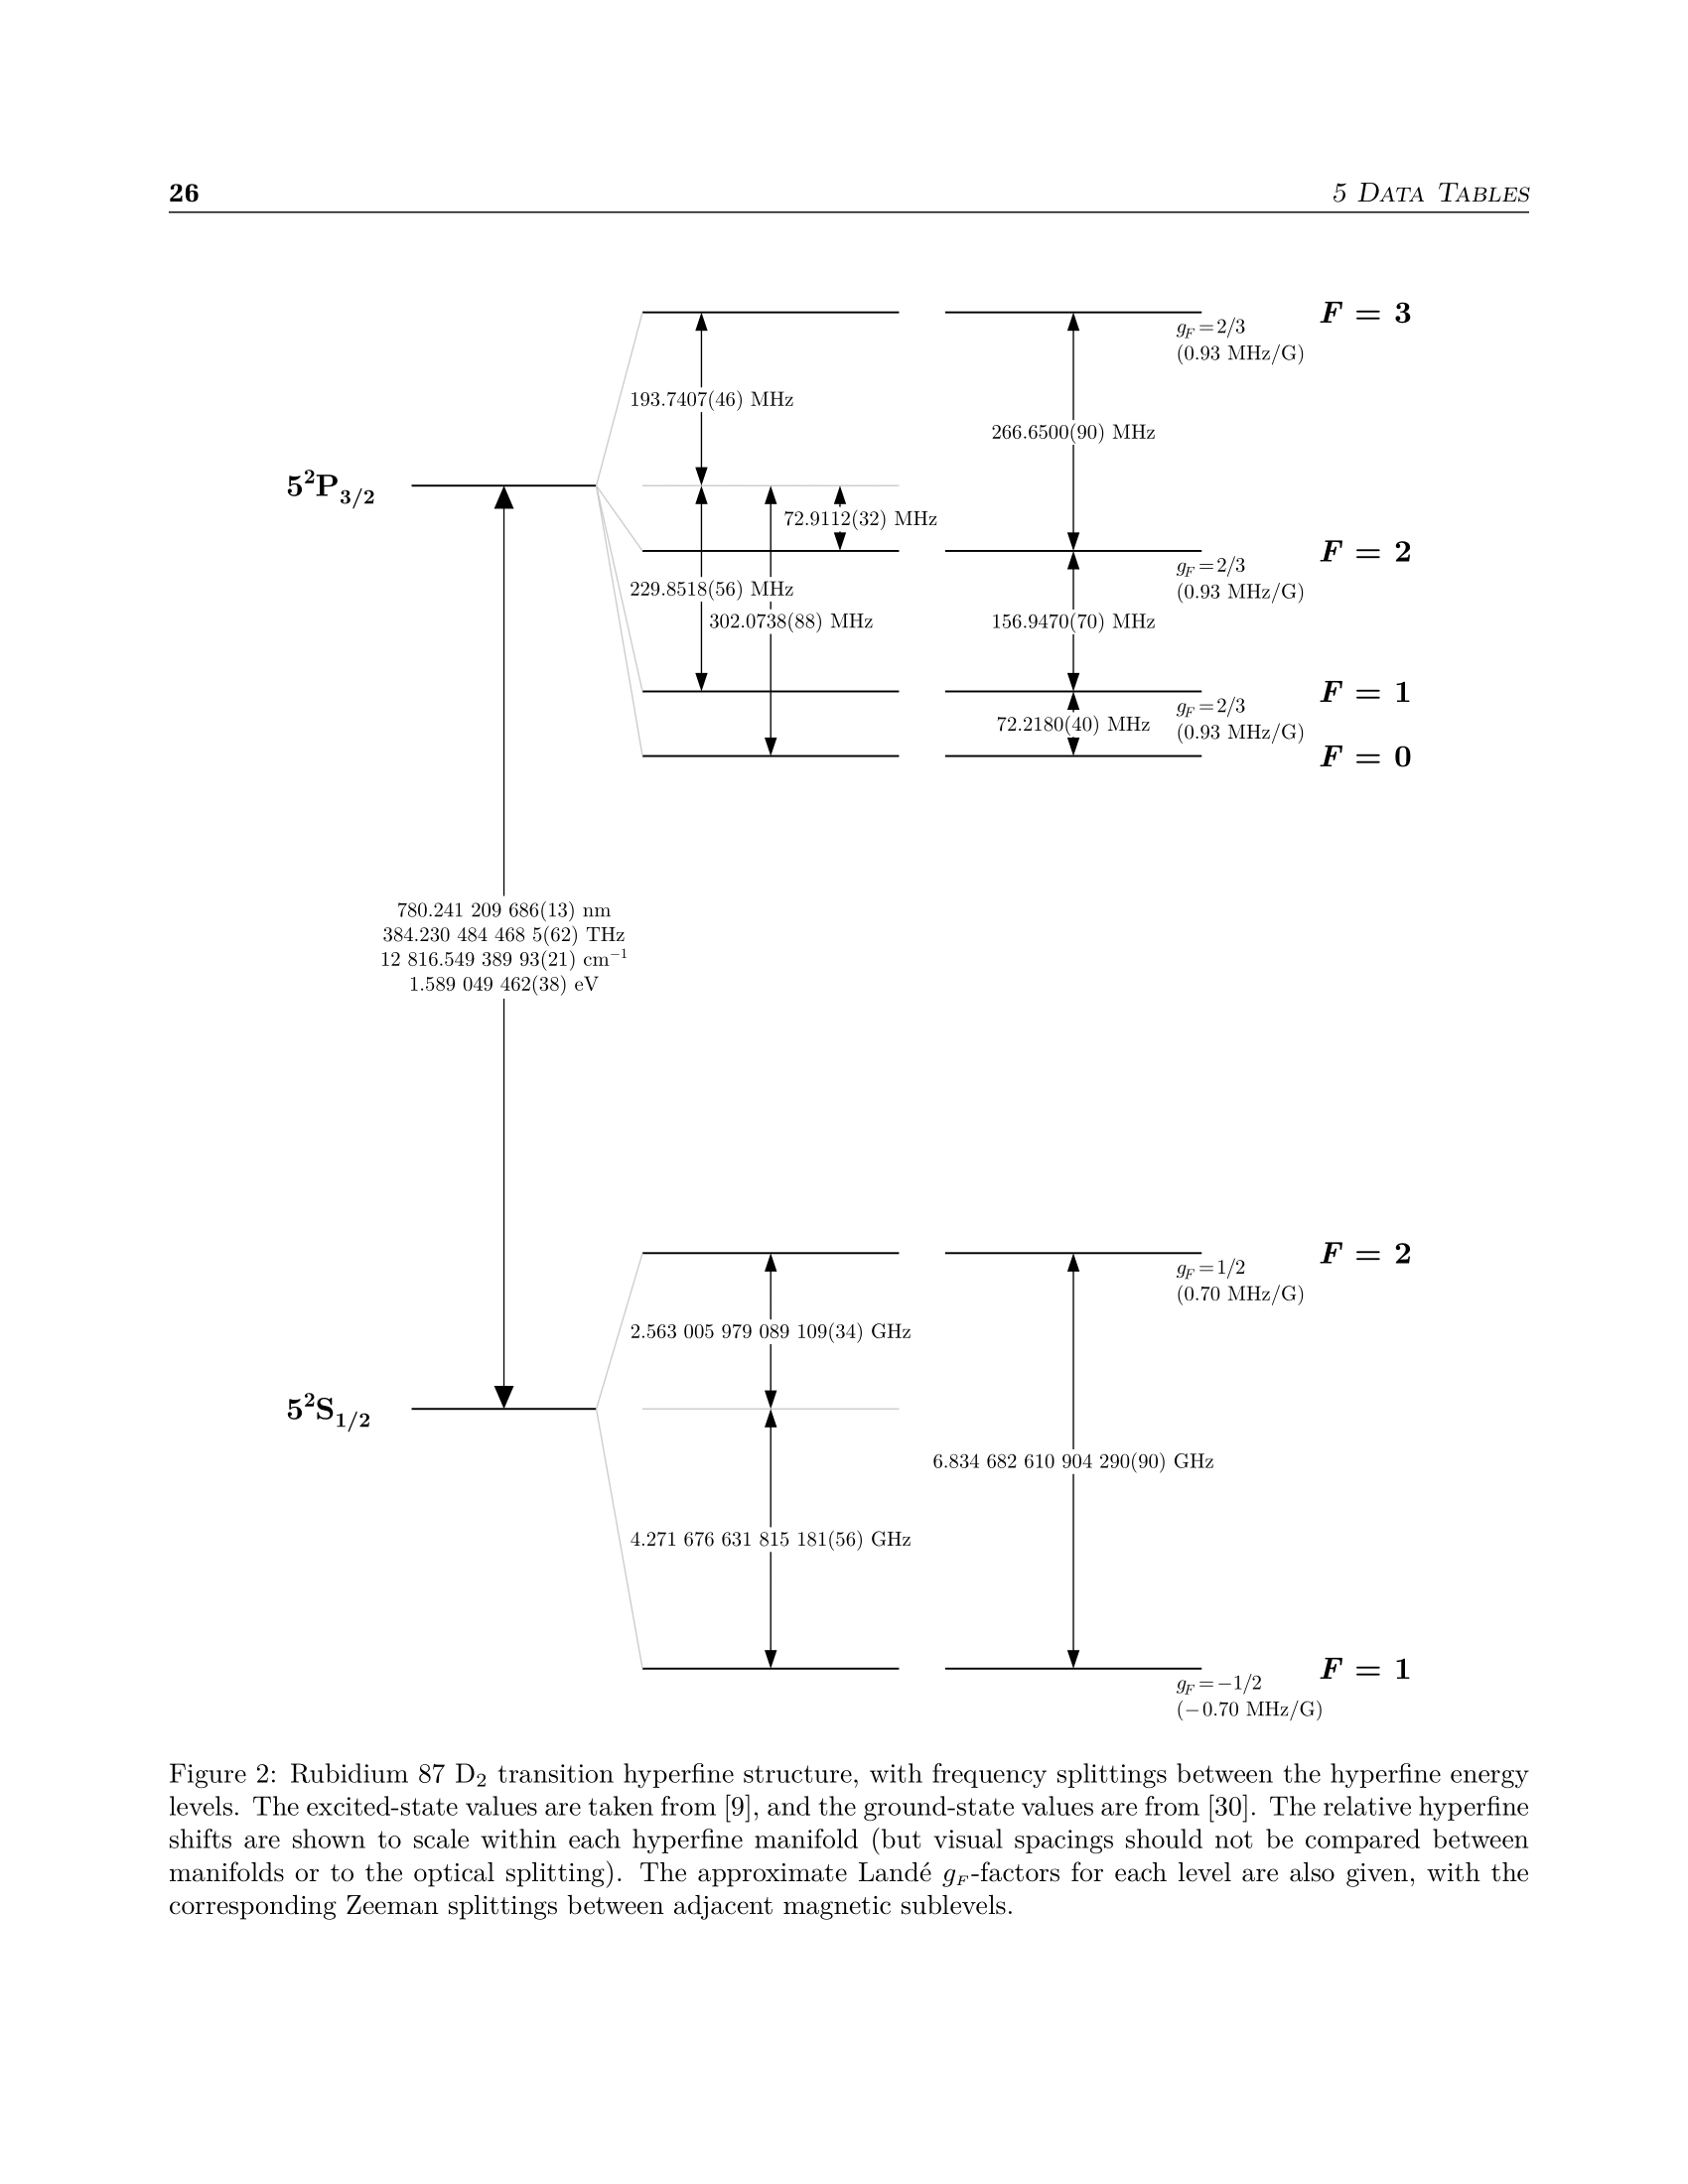

## Calcul des shifts de la transition D2 $|5S_{1/2}, F=2, m_F=2 \rangle \leftrightarrow |5P_{3/2}, F'= 3, m_F =3\rangle$

lambda = 8.2e-07, P=0.0036 W, w=1.2e-06 m, Imax=1.5915mW/um^2, Bf=0.0014
Level 5S_1/2, F=2 - Pola alphasF in units au:
[ 3891.42007027 -1309.20987496     0.        ]
Level 5P_3/2, F=3 - Pola alphasF in units au:
[-1235.80284    -3179.77869978  1267.69747396]
Max Intensity: Imax = 1.5915e+00 mW/µm2
Light shift of level 5S_1/2, F=2, mF = 2: -9.4794e+00 MHz 

Light shift of level 5P_3/2, F=3 (averaged over all M_F): 9.1511 MHz
Light shift of level 5P_3/2, F=3, mF = 3: 3.8906e+01 MHz
Light shift of gnd, mF = 2 --> exc transition, mF = 3: 48.3859 MHz


Light shift averaged of level 5S_1/2, F=2: -1.8282e+01 MHz/(mW/µm2)
Light shift averaged of level 5P_3/2, F=3: 5.7498e+00 MHz/(mW/µm2)
Light shift of level 5P_3/2, F=3, mF = 3: 2.4446e+01 MHz/(mW/µm2)
Light shift averaged of gnd --> exc transition: 2.4032e+01 MHz/(mW/µm2)
Light shift of gnd, mF = 2 --> exc transition, mF = 3: 30.4017 MHz/(mW/µm2)


Light shift averaged of level 5S_1/2, F=2: -8.7740e+02 µK/(mW/µm2)
Light shift averaged of leve

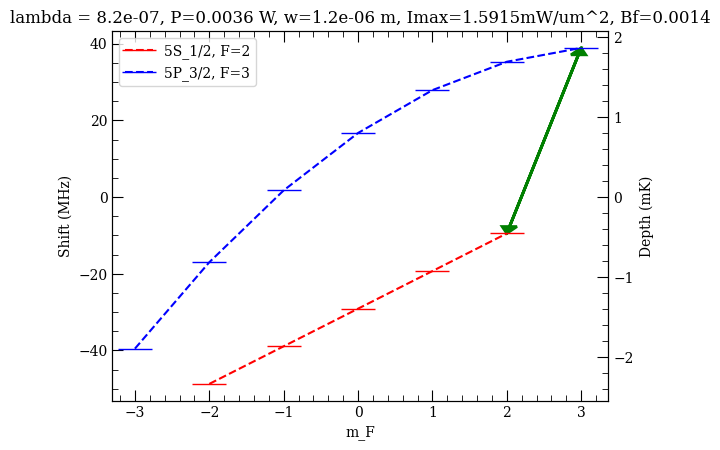

In [11]:
expData = ExperimentData()
expData.Bf=0.0014
expData.P=3.6e-3
expData.setImax() #recompute with P

print(expData)

Ef = Efield() # Creates an Electric field linearly polarized in z direction
Ef.pol = np.array([0.,0.,1.]) #x,y,z complex components of the electric field, z is the quantization axis
Ef.pol *= np.sqrt(expData.Imax)    # Sets the amplitude of the electric field
Ef.normalize() # Normalizes the polarization vector and calculates the sigma+, - and pi components


expunits = 'au'

atome = arc.Rubidium87()

n1 = 5    # Ppal quantum number of ground state
dn = 22    # Delta_n for the calculation basis set

gnd = level(atome)    # Creates an energy level, per default a ground state ==> 5 S_{1/2} F=2
gnd.n = n1
gnd.L = 0
gnd.J = 0.5
gnd.F = 2

gnd.calc_alphasF(expData.lbda, nmin=gnd.atom.groundStateN, nmax=n1+dn, units=expunits)    # Calculates the polarizability

# Defines the n, l, j and f quantum numbers for the excited state ==> 5 P_{3/2} F = 2
n2 = 5
L2 = 1
J2 = L2 + 0.5
F2 = 3

exc = level(atome)    # Creates the excited states and sets its quantum numbers
exc.n = n2
exc.L = L2
exc.J = J2
exc.F = F2
exc.calc_alphasF(expData.lbda, nmin=exc.atom.groundStateN, nmax=n2+dn, units=expunits)    # Calculates the polarizability


#%% Energy level VS mF


# Lists of mF levels for the calculation
mF1List = np.linspace(-gnd.F, gnd.F, 2*int(gnd.F)+1)
shifts_gnd = np.real(gnd.shift(mF1List, Ef, expData.Bf, units = expunits)) # Calculation of the energy shift in Hz

mF2List = np.linspace(-exc.F, exc.F, 2*int(exc.F)+1)
shifts_exc = np.real(exc.shift(mF2List, Ef, expData.Bf, units = expunits)) # Calculation of the energy shift in Hz

transitionofinterest_M_F = [2,3]
printShifts(gnd, exc, expData, shifts_gnd, shifts_exc, mF1List, mF2List, transitionofinterest_M_F)



Ceci est embêtant pour viser une unique transition de pompage optique : (voir figure ci-dessous) pour induire des transitions successives entre |m_F> --> |m_F + 1 > on préfèrerait n'avoir qu'une seule fréquence de résonnance.

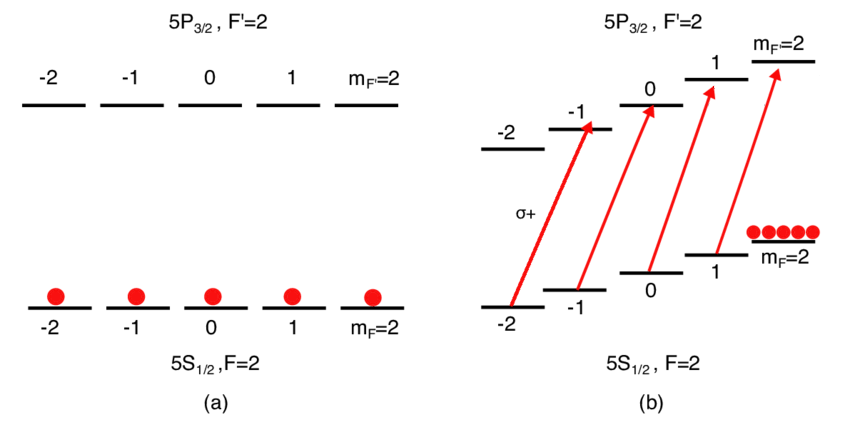

## Calcul des shifts de la transition D2  $|5S_{1/2}, F=2, m_F=1 \rangle \leftrightarrow |5P_{3/2}, F'= 2, m_F =2\rangle$

lambda = 8.2e-07, P=0.0036 W, w=1.2e-06 m, Imax=1.5915mW/um^2, Bf=0.0014
Level 5S_1/2, F=2 - Pola alphasF in units au:
[ 3891.42007027 -1309.20987496     0.        ]
Level 5P_3/2, F=2 - Pola alphasF in units au:
[-1235.80284    -2119.85246652     0.        ]
Max Intensity: Imax = 1.5915e+00 mW/µm2
Light shift of level 5S_1/2, F=2, mF = 1: -1.9288e+01 MHz 

Light shift of level 5P_3/2, F=2 (averaged over all M_F): 9.1511 MHz
Light shift of level 5P_3/2, F=2, mF = 2: 3.5293e+01 MHz
Light shift of gnd, mF = 1 --> exc transition, mF = 2: 54.5807 MHz


Light shift averaged of level 5S_1/2, F=2: -1.8282e+01 MHz/(mW/µm2)
Light shift averaged of level 5P_3/2, F=2: 5.7498e+00 MHz/(mW/µm2)
Light shift of level 5P_3/2, F=2, mF = 2: 2.2175e+01 MHz/(mW/µm2)
Light shift averaged of gnd --> exc transition: 2.4032e+01 MHz/(mW/µm2)
Light shift of gnd, mF = 1 --> exc transition, mF = 2: 34.2940 MHz/(mW/µm2)


Light shift averaged of level 5S_1/2, F=2: -8.7740e+02 µK/(mW/µm2)
Light shift averaged of leve

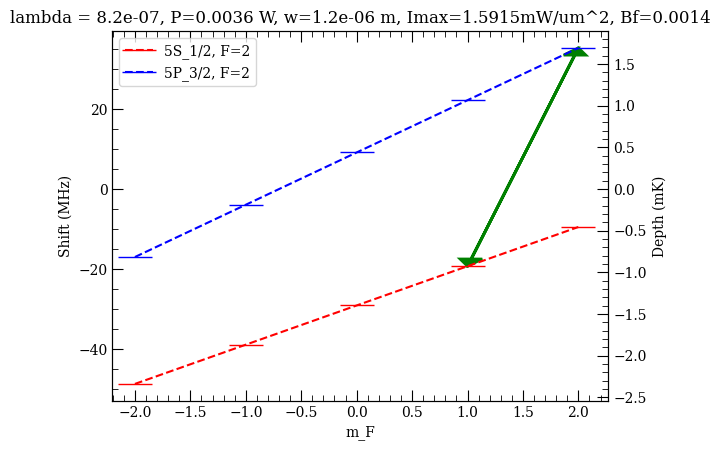

In [12]:

expData.Bf=0.0014
print(expData)

n1 = 5    # Ppal quantum number of ground state
dn = 22    # Delta_n for the calculation basis set

gnd = level(atome)    # Creates an energy level, a ground state ==> 5 S_{1/2} F=2
gnd.n = n1
gnd.L = 0
gnd.J = 0.5
gnd.F = 2


expunits = 'au'

gnd.calc_alphasF(expData.lbda, nmin=gnd.atom.groundStateN, nmax=n1+dn, units=expunits)    # Calculates the polarizability

# Defines the n, l, j and f quantum numbers for the excited state ==> 5 P_{3/2} F = 2
n2 = 5
L2 = 1
J2 = L2 + 0.5
F2 = 2

exc2 = level(atome)    # Creates the excited states and sets its quantum numbers
exc2.n = n2
exc2.L = L2
exc2.J = J2
exc2.F = F2
exc2.calc_alphasF(expData.lbda, nmin=exc2.atom.groundStateN, nmax=n2+dn, units=expunits)    # Calculates the polarizability


#%% Energy level VS mF

# Lists of mF levels for the calculation
mF1List = np.linspace(-gnd.F, gnd.F, 2*int(gnd.F)+1)
newshifts_gnd = np.real(gnd.shift(mF1List, Ef, expData.Bf, units = expunits)) # Calculation of the energy shift in Hz

mF2List = np.linspace(-exc2.F, exc2.F, 2*int(exc2.F)+1)
newshifts_exc = np.real(exc2.shift(mF2List, Ef, expData.Bf, units = expunits)) # Calculation of the energy shift in Hz

printShifts(gnd, exc2, expData, newshifts_gnd, newshifts_exc, mF1List, mF2List, M_F_transition = [1,2])
